In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
class LSTM_predictions_streamlit():
    def __init__(self,df,pred_column,date_col = "timestamp",epoch=10):
        self.df = df
        self.df.dropna(inplace=True)
        self.epoch = epoch
        self.pred_column = pred_column
        self.date_col = date_col
        self.date_formats = (
        '%b-%y','%Y-%m-%d', '%d-%m-%Y', '%m/%d/%Y', '%Y/%m/%d', '%B %d, %Y', '%d-%b-%Y','%b %d, %Y', '%Y-%m',         
        '%m/%Y','%B %Y', '%Y-%m-%d %H:%M', '%d-%m-%Y %H:%M:%S','%m/%d/%Y %I:%M %p','%Y-%m-%dT%H:%M:%S''%a, %d %b %Y %H:%M:%S GMT', '%A, %B %d, %Y'   
        )
        print("Columns: ",self.df.columns)
        print("Data shape: ",self.df.shape)

    def parse_dates(self,date_str):
        for fmt in self.date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt, exact=False)
            except ValueError:
                continue  # Continue trying other formats
        return pd.NaT
    
    def clean_numeric_value(self,value):
        # Remove commas and any non-numeric characters except dot, percent, and minus sign
        value=str(value)
        cleaned_value = re.sub(r'[^\d.]', '', value)
        return str(cleaned_value)

    def preprocess_data(self):
        #print("preprocessing called")
        self.df[self.pred_column] =  self.df[self.pred_column].apply(self.clean_numeric_value)
        self.df[self.pred_column] = pd.to_numeric(self.df[self.pred_column], errors='coerce').astype(float)
        self.df[self.date_col] =  self.df[self.date_col].apply(self.parse_dates)
        print(self.df.info())
        self.df = self.df[[self.date_col,self.pred_column]]
        print("*"*60)

        data = self.df.filter([self.pred_column])
        dataset = data.values

        # Get the number of rows to train the model on
        training_data_len = int(np.ceil( len(dataset) * .80 ))
        train_data = self.df.iloc[0:int(training_data_len), :]
        test_data = self.df.iloc[training_data_len - 60: , :]   

        print("Train size :",train_data.shape)
        print("Test size :",test_data.shape)

        self.train_data = train_data[[self.pred_column, self.date_col]].to_numpy()
        self.test_data = test_data[[self.pred_column, self.date_col]].to_numpy()

        return self.train_data,self.test_data                                      
        print("*"*60)

    def plot(self):
        return self.df

    def create_sequences_lstm(self,data, seq_length=12):
        xs = []
        ys = []
        indices = []
        for i in range(len(data)-seq_length-1):
            x = data[i:(i+seq_length), 0:1]  # Select only the feature columns
            y = data[i+seq_length, 0]  # Select the target value
            xs.append(x)
            ys.append(y)
            indices.append(data[i+seq_length, 1])  # Capture the timestamp for plotting
        return np.array(xs), np.array(ys), np.array(indices)
    
    def create_model(self, X_train):
        model = Sequential()
        model.add(LSTM(160, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.3)) #  0.2
        model.add(LSTM(224, activation='relu', return_sequences=False))
        model.add(Dropout(0.4))  #  0.2
        model.add(Dense(112, activation='relu'))  # Adding a dense layer with activation function relu
        model.add(Dense(1))
        model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error', 'mean_squared_error','accuracy'],)
        return model
    
    def train_loss(self,history):
        loss_data = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']})

        loss_data.set_index('Epoch', inplace=True)
        return loss_data
    
    def evaluate_model(self,y_train,y_train_pred,y_test,y_test_pred):
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
       
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        return train_rmse,test_rmse,train_mae,test_mae
    
    def df_for_plot(self,indices,y,y_pred):
        data = pd.DataFrame({
        'Date': pd.to_datetime(indices),
        'actual': y.flatten(),
        'predicted': y_pred.flatten()})

        # Set 'train_indices' column as index
        data.set_index('Date', inplace=True)
        return data
    
    def predict_test_data(self, model, X_test):
        """
        Predict values using the trained LSTM model.
        
        Parameters:
        - model: The trained LSTM model.
        - X_test: The test dataset.
        
        Returns:
        - y_test_pred: Predicted values for the test dataset.
        """
        # Reshape X_test if necessary
        if len(X_test.shape) == 2:
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Predict values using the model
        y_test_pred = model.predict(X_test)

        return y_test_pred

In [3]:
df = pd.read_csv('workstation_data.csv')

In [4]:
model = LSTM_predictions_streamlit(df,'energy')

Columns:  Index(['timestamp', 'voltage', 'current', 'power', 'frequency', 'energy', 'fp',
       'ESP32_temp', 'WORKSTATION_CPU', 'WORKSTATION_CPU_POWER',
       'WORKSTATION_CPU_TEMP', 'WORKSTATION_GPU', 'WORKSTATION_GPU_POWER',
       'WORKSTATION_GPU_TEMP', 'WORKSTATION_RAM', 'WORKSTATION_RAM_POWER'],
      dtype='object')
Data shape:  (22857, 16)


In [5]:
train_data,test_data = model.preprocess_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22857 entries, 0 to 22856
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   timestamp              22857 non-null  datetime64[ns]
 1   voltage                22857 non-null  float64       
 2   current                22857 non-null  float64       
 3   power                  22857 non-null  float64       
 4   frequency              22857 non-null  float64       
 5   energy                 22857 non-null  float64       
 6   fp                     22857 non-null  float64       
 7   ESP32_temp             22857 non-null  float64       
 8   WORKSTATION_CPU        22857 non-null  float64       
 9   WORKSTATION_CPU_POWER  22857 non-null  float64       
 10  WORKSTATION_CPU_TEMP   22857 non-null  float64       
 11  WORKSTATION_GPU        22857 non-null  float64       
 12  WORKSTATION_GPU_POWER  22857 non-null  float64       
 13  W

In [6]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1, 1)) # or any other range you prefer, (-1,1) is for (0,1) normalization


In [7]:
#scaler = MinMaxScaler(feature_range=(-1, 1)) # (0,1)
train_data[:, 0] = scaler.fit_transform(train_data[:, 0].reshape(-1, 1)).flatten()
test_data[:, 0] = scaler.transform(test_data[:, 0].reshape(-1, 1)).flatten() 


In [8]:
print(test_data)   
print(len(test_data))
print(type(test_data))

[[0.9950442167532234 Timestamp('2021-07-16 00:00:00')]
 [0.9950888218786602 Timestamp('2021-07-16 00:00:00')]
 [0.9952205864446046 Timestamp('2021-07-16 00:00:00')]
 ...
 [1.3964488167721423 Timestamp('2021-08-02 00:00:00')]
 [1.3965862464299694 Timestamp('2021-08-02 00:00:00')]
 [1.3965933989028674 Timestamp('2021-08-02 00:00:00')]]
4631
<class 'numpy.ndarray'>


In [9]:
X_train, y_train,indices_train  = model.create_sequences_lstm(train_data)
X_test, y_test,indices_test = model.create_sequences_lstm(test_data)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [12]:
lstm_model = model.create_model(X_train)

c:\Users\vinee\anaconda3\envs\home\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
history = lstm_model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0298 - mean_absolute_error: 0.0931 - mean_squared_error: 0.0298 - val_accuracy: 2.1654e-04 - val_loss: 0.0278 - val_mean_absolute_error: 0.1654 - val_mean_squared_error: 0.0278
Epoch 2/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0023 - mean_absolute_error: 0.0345 - mean_squared_error: 0.0023 - val_accuracy: 2.1654e-04 - val_loss: 0.0239 - val_mean_absolute_error: 0.1519 - val_mean_squared_error: 0.0239
Epoch 3/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0016 - mean_absolute_error: 0.0309 - mean_squared_error: 0.0016 - val_accuracy: 2.1654e-04 - val_loss: 8.0957e-04 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 8.0957e-04
Epoch 4/100
572/572 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0011 - mean_absolute_error: 0.0256 - mean_squared_error: 0.0011 - val_accuracy: 2.1654e-04 - val_loss: 0.0030 

In [14]:
# Make predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Calculate error metrics
train_rmse, test_rmse, train_mae, test_mae = model.evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

# Print error metrics
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)


572/572 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train RMSE: 0.0754422
Test RMSE: 0.9536395
Train MAE: 0.063449115
Test MAE: 0.8037522


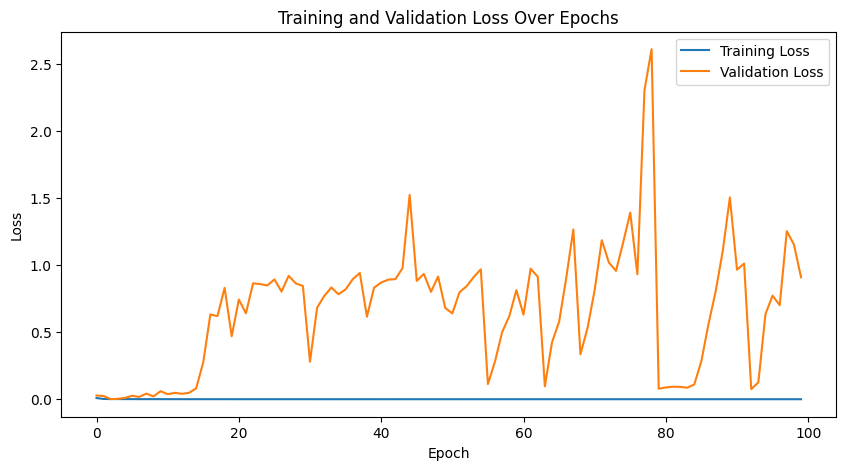

In [15]:
import matplotlib.pyplot as plt

# Plot 1: Training and Validation Loss Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


 

In [16]:
y_test_pred = model.predict_test_data(model, X_test)

# Plot predicted vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'LSTM_predictions_streamlit' object has no attribute 'predict'